The point of this notebook is to:

1. Use the merged tiles from a map server and make a water mask for orinoco
    + select the colors that indicate water and make a water mask
    + reproject into UTM for use with ornioco (we assume all masks are in UTM for Orinoco)
2. Use a shapefile to create a initialization mask for the Fast Marching Method.

We have some wrappers for rasterio, but wherever possible expose how to use rasterio, a python library for GIS and raster reading and writing. The best resource for getting up to speed with the power of rasterio is their [quickstart](https://rasterio.readthedocs.io/en/latest/quickstart.html). We also created some materials related to radar remote sensing that discuss some python/GIS [here](https://github.com/cmarshak/sari-tutorial). 

In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pyproj
import geopandas as gpd
from rasterio import features
from rasterio.crs import CRS
from rasterio.warp import transform_bounds
import scipy.ndimage as nd
from shapely.geometry import Polygon, shape, LinearRing, LineString, MultiPolygon
from orinoco import (filter_binary_array_by_min_size,
                     reproject_arr_to_new_crs,
                     reproject_profile_to_new_crs,
                     reproject_arr_to_match_profile,
                     convert_4326_to_utm,
                     scale_img,
                     rasterize_shapes_to_array,
                     polygonize_array_to_shapefile)
import scipy.ndimage as nd

# Loading the Merged Tiff of Map Tiles

We are going to create directories for our out put products to be saved to. We have two options:

1. `stamen_terrain_12`
2. `google_16`

*Warning*: `google_16` has a high spatial resolution (2 meters) and will take significantly more time to process (and display using `imshow`) at each stage. You may want to comment the `imshow` commands if processing google.

Change the `map_name` below to toggle between these options.

In [2]:
# options are `stamen_terrain_12` or `google_16`
map_name = 'google_16'  
data_path = Path(f'data/{map_name}')

In [3]:
product_dir = Path('products')
product_dir.mkdir(exist_ok=True)

In [4]:
products_for_map_dir = product_dir/map_name
products_for_map_dir.mkdir(exist_ok=True)

We use rasterio for raster I/O (get it?). The profile encodes all the releventa geographic metadata. 

In [5]:
with rasterio.open(data_path/f'{map_name}.tif') as ds:
    src_arr = ds.read()
    bounds = ds.bounds
    src_profile = ds.profile
    src_crs = dict(ds.crs)
src_profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 20398, 'height': 16534, 'count': 4, 'crs': CRS.from_epsg(3857), 'transform': Affine(2.388692083548112, 0.0, -10192112.014406987,
       0.0, -2.3886789876076677, 3462892.8103504805), 'tiled': False, 'compress': 'lzw', 'interleave': 'pixel'}

We have to convert this to BSQ (band sequential) for numpy and select first 3 bands. We will see in later notebooks how to use rasterio for pretty plotting. 

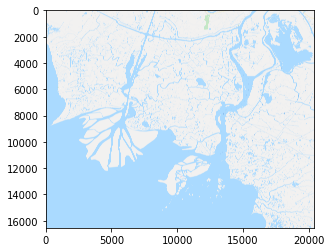

In [6]:
plt.imshow(src_arr.transpose([1, 2, 0])[..., :3])

# Extract Water Mask from Merged Tile Image

We used QGIS to determine approximate color of water and some of the text labels, if any. Below the function takes the 3 values of color we select and find some neighborhood around those colors to use as waters (`tol` = 3).

In [7]:
def obtain_mask_from_color(arr, rgb_fixed, tol=3):
    """
    Looking at the first 3 channels of our image, we look at +/- 
    tolerance within some fixed 3 channel value (given by rgb_fixed)
    """
    X = arr.astype(float)
    mask_r = np.abs(X[..., 0] - rgb_fixed[0]) < tol
    mask_g = np.abs(X[..., 1] - rgb_fixed[1]) < tol
    mask_b = np.abs(X[..., 2] - rgb_fixed[2]) < tol
    return mask_r & mask_g & mask_b

There is nothing pretty or elegant about this process. The good news is that once the colors are selected, which is pretty painless, this approach will work for these tiles globally, which generally have good coverage globally. Below, are colors that we have selected for both of the maps we have downloaded. Note for Google maps, there is a bit more "finesse" in that we have to remove text from the water bodies.

In [8]:
X = src_arr.transpose([1, 2, 0])[..., :3]


if map_name == 'stamen_terrain_12':
    # The stamen mask doesn't have any text in it
    mask_original_crs = obtain_mask_from_color(X, [153, 179, 204])
    
    
elif map_name == 'google_16':
    #We not only need water but the various text values 
    # littered around the map. This is denoted by `mask_text_<i>`.
    mask_water = obtain_mask_from_color(X, [170, 218, 255])
    
    mask_text_0 = obtain_mask_from_color(X, [122, 158, 174])
    mask_text_1 = obtain_mask_from_color(X, [126, 146, 158])
    mask_text_2 = obtain_mask_from_color(X, [99, 150, 213])
    mask_text_3 = obtain_mask_from_color(X, [75, 130, 198])

    mask_text = mask_text_0 | mask_text_1 | mask_text_2 | mask_text_3

    # To make sure the text gets removed we are going to create a 2 pixel buffer.
    mask_text = nd.morphology.binary_dilation(mask_text, 
                                              iterations=2,
                                              border_value=0,
                                              structure=np.ones((3, 3)))


    mask_original_crs = mask_text | mask_water
    
else:
    raise ValueError('only works for google_16 and stamen_terrain_12')

In updates to matplotlib, there is default smoothing that occurs and hence the `interpolation` parameter must be used. Specifically, the default interpolation [`antialiasing`](https://matplotlib.org/3.2.1/gallery/images_contours_and_fields/interpolation_methods.html) may smooth out large downsampled images and thus our specification removing such interpolation.

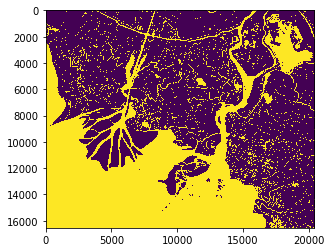

In [9]:
plt.imshow(mask_original_crs, interpolation='none')

In [10]:
src_profile['count'] = 1
with rasterio.open(products_for_map_dir/'water_mask_original.tif', 'w', **src_profile) as ds:
    ds.write(mask_original_crs.astype(np.uint8), 1)

# Convert Mask into UTM

Orinoco requires a UTM mask (i.e. a mask in which the resolution cells are measured in meters) so that the signed distance function ($\varphi$) has some real meaning. Map server tiles are typically in [Web Mercator Projection](https://en.wikipedia.org/wiki/Web_Mercator_projection), i.e. `epsg:3857`. To get into UTM, we determine the lat, lon and use the center of our mask to determine an appropriate UTM zone. In Northern latitudes where distances are not intuitive on the resulting non-UTM CRS, such a conversion into UTM ensures that a user can make sense of each step of the pipeline we are proposing.

To do so, we will:

1. Find the appropriate UTM zone using the bounding box of our current array
2. Reproject our array into this utm zone with a reasonable resolution

For 1, we have to first translate our bounds to (lon, lat) so that we can determine our utm zone.

In [11]:
bounds_4326 = transform_bounds(src_crs, {'init':'epsg:4326'}, *bounds)
bounds_4326

(-91.55729999999998, 29.374499999999955, -91.11959999999999, 29.68319999999997)

In [12]:
midpoint = (bounds_4326[0] + bounds_4326[2]) / 2, (bounds_4326[1] + bounds_4326[3]) / 2
midpoint

(-91.33845, 29.528849999999963)

In [13]:
epsg_utm = CRS({'init':convert_4326_to_utm(*midpoint)})
epsg_utm

CRS.from_epsg(32615)

Now, we reproject to this UTM zone.

In [14]:
if map_name == 'stamen_terrain_12':
    target_resolution = 25
elif map_name == 'google_16':
    target_resolution=2
else:
    raise ValueError('only works for google_16 and stamen_terrain_12')

profile_utm = reproject_profile_to_new_crs(src_profile, 
                                           epsg_utm,
                                           # 2 meter resolution; closely matches tif in QGIS
                                           target_resolution=target_resolution
                                           )

We make sure we adjust the `count` key in the profile, which specifies the number of channels.

In [15]:
src_profile['count'] = 1
profile_utm['count'] = 1
mask, _ = reproject_arr_to_match_profile(mask_original_crs.astype(np.uint8), 
                                         src_profile, 
                                         profile_utm,
                                         resampling='nearest', 
                                        )
# We only need the first channel and so we remove the extra first dimension
mask = mask[0, ...].astype(bool)

## Dilation and Erosion

It is very helpful to remove erroneous land pixels within the channels buffer our mask and then contracting it. We use the scipy's `ndimage` module.

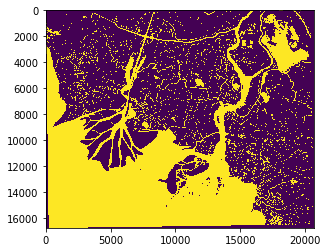

In [16]:
mask = nd.binary_dilation(mask, iterations=1, structure=np.ones((3, 3)))
mask = nd.binary_erosion(mask, iterations=1, structure=np.ones((3, 3)))
plt.imshow(mask, interpolation='none')

## Saving the Mask

We used QGIS on the original mask to determine approximate color of water and some of the text labels.

In [17]:
profile_utm['count'] = 1
with rasterio.open(products_for_map_dir/'water_mask.tif', 'w', **profile_utm) as ds:
    ds.write(mask.astype(np.uint8), 1)

# Interface Mask / Ocean Mask

I drew these polygons pretty quickly in QGIS. They approxiamte where the channels run into the ocean with respect to the above tiff. This interface is slightly different for Google and Stamen water masks because each image highlights different islands, have different shorelines, etc. 

One could use this hydropolys [dataset](https://apps.gis.ucla.edu/geodata/dataset/world_water_bodies/resource/a6b40af0-84cb-40ce-b1c5-b024527a6943) to automate this process (the shapefiles indicate ocean vs. river vs. lake, etc), but then there are still differences in the shorelines. Likely there would need to be some sort of post-processing of the network (or hand editing of the resulting intialization mask) to ensure reasonable networks. Similar to editing is done in RivGraph [here](https://github.com/jonschwenk/RivGraph/blob/master/examples/delta_example.py.ipynb).

/Users/cmarshak/anaconda3/envs/orinoco_env/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


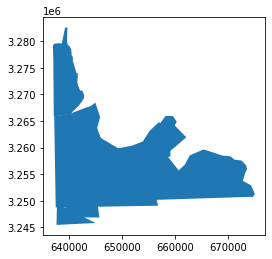

In [18]:
ocean_shapefile = data_path/f'{map_name}_interface'
ocean_df = gpd.read_file(ocean_shapefile).dropna().to_crs({'init': epsg_utm})
ocean_df.plot()

We extract the above geometry and combine all the geometries into a single `Shapley` polygon so that we can export it to a raster. We also provide a small buffer (in the original CRS of the map).

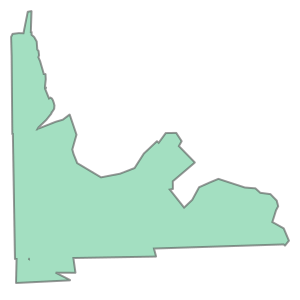

In [19]:
ocean_geometry = ocean_df.geometry.unary_union.buffer(30)
ocean_geometry

We will take this geometry and translate it into a raster again using rasterio's [`rasterize`](https://rasterio.readthedocs.io/en/latest/topics/features.html#burning-shapes-into-a-raster).

In [20]:
def translate_one(geometry, profile):
    """
    The geometry and profile need to have the same epsg codes otherwise this will fail (silently).
    """
    shapes = [(geometry, 1)]
    out_arr = np.zeros((profile['height'], profile['width']))
    burned = features.rasterize(shapes=shapes,
                                out=out_arr,
                                transform=profile['transform'],
                                all_touched=True)
    return burned

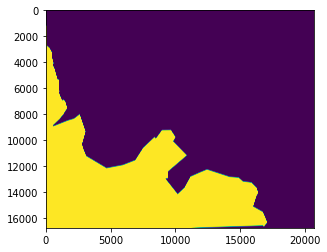

In [21]:
ocean_mask = translate_one(ocean_geometry, profile_utm)
plt.imshow(ocean_mask)

The channel mask will be defined as the water mask minus the ocean mask.

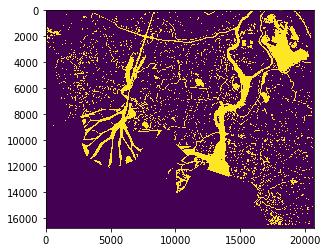

In [22]:
channel_mask = mask.astype(bool) & ~ocean_mask.astype(bool)
plt.imshow(channel_mask, interpolation='none')

We now save the two above masks to our product directory.

In [23]:
with rasterio.open(products_for_map_dir/'ocean_mask.tif', 'w', **profile_utm) as ds:
    ds.write(ocean_mask.astype(np.uint8), 1)
with rasterio.open(products_for_map_dir/'channel_mask.tif', 'w', **profile_utm) as ds:
    ds.write(channel_mask.astype(np.uint8), 1)